# Transfer Learning with ResNet
The project revolves around implementing transfer learning using PyTorch to enhance the training efficiency and performance of machine learning models. Transfer learning, an advanced technique, involves using pre-trained models to expedite the training of new models, thereby reducing the required time and computational resources. PyTorch, a widely-used open-source machine learning library, facilitates this process by providing tools to load and fine-tune pre-trained models with new datasets.



In [ ]:
# Importing necessary libraries for deep learning, data manipulation, and model training
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms

## Feature extraction
Feature extraction is a transfer learning technique where a pre-trained model, usually trained on a large dataset like ImageNet, is used to extract meaningful features from a new dataset. In this approach, we leverage the learned representations from the pre-trained model, which are often robust and generalizable. The process involves the following steps:

- Loading a Pre-Trained Model: We load a model that has been pre-trained on a large and diverse dataset.
- Freezing Layers: The layers of the pre-trained model are frozen, meaning their weights are not updated during training. This ensures that the learned features remain intact.
- Adding Custom Layers: A new fully connected (FC) layer or a series of layers are added to the model to adapt it to the specific task at hand, such as classifying a different set of images.
- Training Only the Custom Layers: During training, only the newly added layers are trained, while the pre-trained layers remain unchanged. This significantly reduces the computational cost and the amount of data needed for training.

## Data Loading and Preprocessing
Here, we apply transformations to resize images, convert them to tensors, and normalize. Then we load the CIFAR-10 dataset and preparing DataLoader for batch processing.

In [ ]:
# Define transformations to apply to the dataset
transform = transforms.Compose([
    transforms.Resize(224),                 # Resize the images to 224x224 pixels
    transforms.ToTensor(),                       # Convert the images to PyTorch tensors
    transforms.Normalize((0.485, 0.456, 0.406),  # Normalize the images with mean and std deviation for each channel
                         (0.229, 0.224, 0.225))
])

# Load the CIFAR-10 training dataset, apply the transformations, and set up the DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Load the CIFAR-10 validation dataset, apply the same transformations, and set up the DataLoader
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 30134893.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Load model
Here, we want to Load the pre-trained ResNet-18 model and freeze its layers to retain pre-learned features, The Feature Extraction phase. At the end, we replace the final fully connected layer to adapt it to the CIFAR-10 classification task.

In [ ]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(weights=True)

# Freeze all layers in the model to prevent their weights from being updated during training
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features for the last fully connected layer
num_ftrs = model.fc.in_features  # Typically equals 512 for ResNet-18

# Replace the last fully connected layer with a custom sequential model
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


## Train last layers of the model
Here, we define the loss function and optimizer, run the training loop for 20 epochs, updating model weights based on training data, and calculating losses for both training and validation sets.

*Note that we are only training the newly added fully connected layers while the rest of the model remains frozen to leverage the pre-trained features.*



In [ ]:
# Transport model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
# Loss functiona & Optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
# Lists to store loss values
train_losses = []
val_losses = []

for epoch in range(20):
    # Training phase
    model.train()
    epoch_train_loss = 0
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            loss = criterion(val_outputs, y_val)
            epoch_val_loss += loss.item()

    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/20], Training Loss: {epoch_train_loss:.4f},\
         Validation Loss: {epoch_val_loss:.4f}')

Epoch [5/20], Training Loss: 0.6077,         Validation Loss: 0.5613
Epoch [10/20], Training Loss: 0.5478,         Validation Loss: 0.5249
Epoch [15/20], Training Loss: 0.4996,         Validation Loss: 0.5113
Epoch [20/20], Training Loss: 0.4572,         Validation Loss: 0.4970


## Loss function and Learning Curve
The loss function measures how well a machine learning model's predictions match the actual outcomes, with the goal of minimizing this error during training. The learning curve plots the loss against the number of training epochs, showing the model's performance improvement over time. By visualizing these curves, we can diagnose issues like overfitting or underfitting and adjust the training process accordingly.

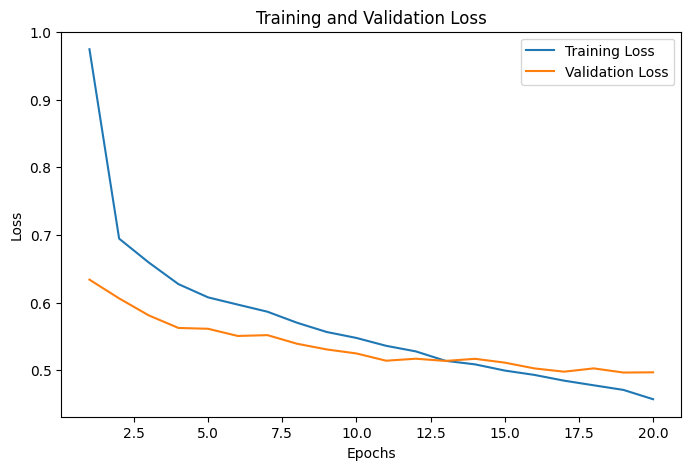

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(range(1, 21), train_losses, label='Training Loss')
plt.plot(range(1, 21), val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Prediction phase
Here, we evaluate the trained model on the validation set by disabling gradient calculations and Caluculate the accuracy based on the predicted and actual labels.

In [ ]:
# Lists to store all predictions and labels
all_predictions = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for X_test, y_test in val_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)

        outputs = model(X_test)

        # Apply softmax to get the class probabilities
        probabilities = nn.functional.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)

        all_predictions.extend(predicted_classes.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

# Calculate the number of correct predictions
correct_predictions = (np.array(all_predictions).flatten() == np.array(all_labels)).sum()

# Calculate the accuracy
accuracy = correct_predictions / len(all_labels)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8318


## Fine Tuning
Fine-tuning is another transfer learning technique where we further train a pre-trained model on a new dataset. Unlike feature extraction, in fine-tuning, we allow some or all layers of the pre-trained model to be updated during training. This process involves:

- Loading a Pre-Trained Model: A pre-trained model, trained on a large dataset, is loaded.
- Unfreezing Layers: Some or all of the layers are unfrozen, allowing their weights to be updated during training.
- Adding Custom Layers: Similar to feature extraction, new fully connected layers may be added to adapt the model to the new task.
- Training the Model: The entire model, including both the pre-trained layers and the newly added layers, is trained on the new dataset. This allows the model to fine-tune the learned features to better fit the specific characteristics of the new data.

## Load model
Here, we load the pre-trained ResNet-18 model and enable training for all layers to fine-tune the entire model. At the end, we replace the final fully connected layer to adapt it to the CIFAR-10 classification task.

In [ ]:
# Load the pre-trained ResNet-18 model with weights pre-trained on ImageNet
model = models.resnet18(weights=True)

# Enable training for all layers in the model by setting requires_grad to True
for param in model.parameters():
    param.requires_grad = True

# Get the number of input features for the last fully connected layer
num_ftrs = model.fc.in_features  # Typically 512 for ResNet-18

# The new linear layer has num_ftrs input features and 10 output features (for 10 classes)
model.fc = nn.Linear(num_ftrs, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


## Train the model
Here, we define the loss function and optimizer. Then we run the training loop for 20 epochs, update model weights based on training data, and calculate losses for both training and validation sets.

*Note that in fine-tuning, we are training all the layers of the model, not just the newly added fully connected layers, to adjust the pre-trained features to our specific task.*

In [ ]:
# Transport model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
# Define a path to save best model
import os
model_dir = "model_checkpoints"
os.makedirs(model_dir, exist_ok=True)

In [ ]:
# Lists to store loss values
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_epoch = 0

for epoch in range(30):
    # Training phase
    model.train()
    epoch_train_loss = 0
    # Get x, y of each batch
    for X_train, y_train in train_loader:
      # Transpos data to cuda
      X_train, y_train = X_train.to(device), y_train.to(device)
      # clear gradients
      optimizer.zero_grad()
      # model predictions
      outputs = model(X_train)
      # calculate loss between preds and real values
      loss = criterion(outputs, y_train)
      # backpropagation
      loss.backward()
      # update weights
      optimizer.step()
      epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            loss = criterion(val_outputs, y_val)
            epoch_val_loss += loss.item()

    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/30], Training Loss: {epoch_train_loss:.4f},\
         Validation Loss: {epoch_val_loss:.4f}')

    # Check if the validation loss improved for Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        # Save the best model
        torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pth'))
        print(f'Best model saved at epoch {epoch + 1}')

Best model saved at epoch 1
Best model saved at epoch 2
Best model saved at epoch 3
Best model saved at epoch 4
Epoch [5/30], Training Loss: 0.6693,         Validation Loss: 0.6250
Best model saved at epoch 5
Best model saved at epoch 6
Best model saved at epoch 7
Best model saved at epoch 8
Best model saved at epoch 9
Epoch [10/30], Training Loss: 0.6133,         Validation Loss: 0.5891
Best model saved at epoch 10
Best model saved at epoch 11
Best model saved at epoch 12
Epoch [15/30], Training Loss: 0.5949,         Validation Loss: 0.5767
Best model saved at epoch 15
Best model saved at epoch 16
Best model saved at epoch 18
Best model saved at epoch 19
Epoch [20/30], Training Loss: 0.5801,         Validation Loss: 0.5686
Best model saved at epoch 20
Best model saved at epoch 21
Best model saved at epoch 22
Best model saved at epoch 23
Epoch [25/30], Training Loss: 0.5761,         Validation Loss: 0.5668
Best model saved at epoch 26
Best model saved at epoch 27
Best model saved at ep

## Plotting Loss function and Learning Curve

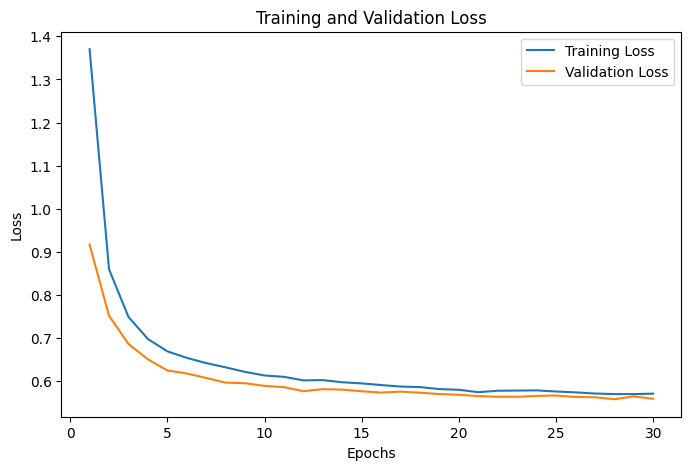

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(range(1, 31), train_losses, label='Training Loss')
plt.plot(range(1, 31), val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Prediction phase
Here, we evaluate the trained model on the validation set by disabling gradient calculations and Caluculate the accuracy based on the predicted and actual labels.

In [ ]:
# Lists to store all predictions and labels
all_predictions = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for X_test, y_test in val_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)

        outputs = model(X_test)

        # Apply softmax to get the class probabilities
        probabilities = nn.functional.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)

        all_predictions.extend(predicted_classes.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

# Calculate the number of correct predictions
correct_predictions = (np.array(all_predictions).flatten() == np.array(all_labels)).sum()

# Calculate the accuracy
accuracy = correct_predictions / len(all_labels)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8117


## Drawing Feature maps
The code snippet provided below is designed to capture and store the feature maps from the first and last convolutional layers of a neural network model, specifically a ResNet architecture. First, a dictionary named `feature_maps` is initialized to hold the outputs of these layers. The `get_feature_maps` function is defined to create a hook function that, when called, stores the output of a layer (detached from the computation graph to save memory) into the feature_maps dictionary using a specified key. This hook function is then registered to the first convolutional layer of the first block `(model.layer1[0].conv1)` and the second convolutional layer of the last block `(model.layer4[1].conv2)` using the `register_forward_hook` method. By doing this, the hook functions are set to be executed during the forward pass of these layers, capturing and storing their feature maps in the dictionary under the keys `first_conv` and `last_conv`, respectively. This setup allows for the extraction and later visualization of the feature maps from these specific layers after a forward pass through the model.

In [ ]:
# Define a dictionary to store feature maps
feature_maps = {}

# Define hook function
def get_feature_maps(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach()
    return hook

# Register hooks to the first and last convolutional layers
model.layer1[0].conv1.register_forward_hook(get_feature_maps('first_conv'))
model.layer4[1].conv2.register_forward_hook(get_feature_maps('last_conv'))

Here we have two main functions, `normalize_image` and `plot_feature_maps`, along with a series of operations to visualize feature maps from a neural network.

The `normalize_image` function normalizes image pixel values, scaling them to the range [0, 1] for float32 and float64 data types, and [0, 255] for uint8 data types.

The `plot_feature_maps` function plots the feature maps of a sample image from the neural network. It first converts the feature maps and the sample image to numpy arrays, normalizes the sample image, and sets up a plot with subplots to display both the original image and several feature maps. It then plots the original image and a specified number of feature maps side by side.

After ensuring the model is in evaluation mode, a batch of sample inputs is loaded, and a forward pass is performed.

Finally, feature maps from specified layers (`first_conv` and `last_conv`) are retrieved and plotted using `plot_feature_maps`.

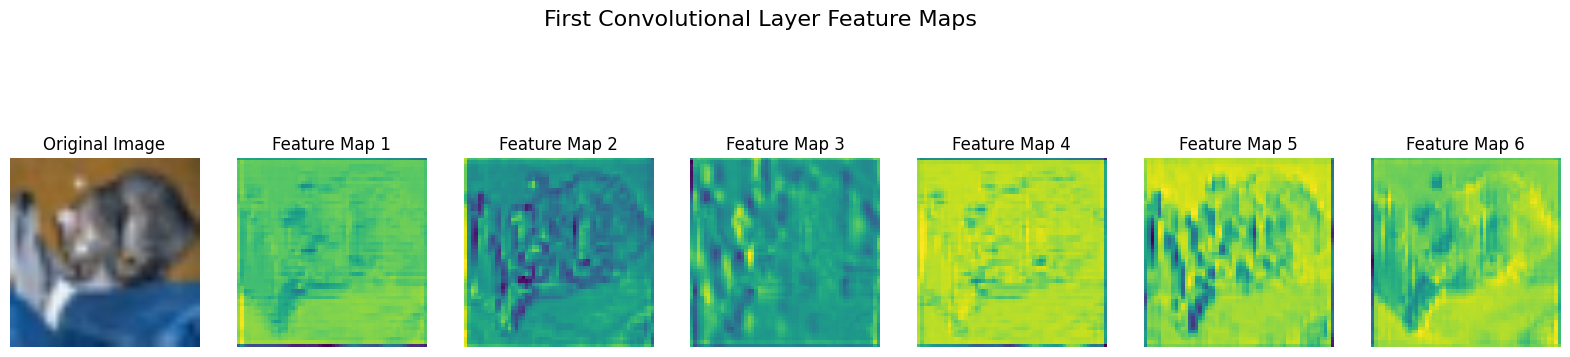

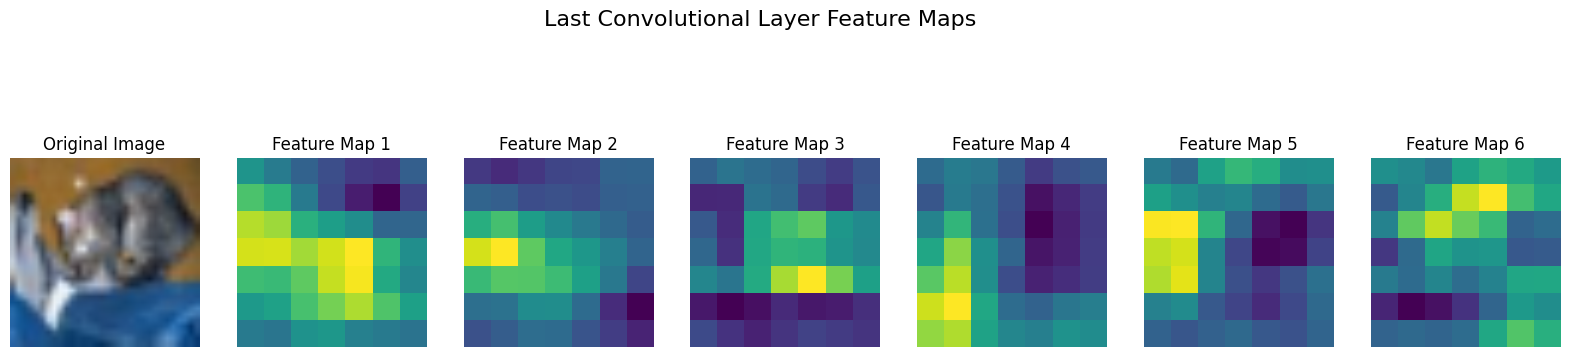

In [ ]:
def normalize_image(image):
    """Normalize the image to [0, 1] range for float32 and [0, 255] for uint8."""
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image - image.min()) / (image.max() - image.min())
    elif image.dtype == np.uint8:
        image = 255 * (image - image.min()) / (image.max() - image.min())
    return image

def plot_feature_maps(sample_image, feature_maps, title, num_channels=6):
    # Move feature maps to CPU and convert to numpy arrays
    feature_maps = feature_maps.cpu().detach().numpy()
    sample_image = sample_image.cpu().detach().numpy().transpose(1, 2, 0)  # Transpose to HWC format
    sample_image = normalize_image(sample_image)  # Normalize the sample image

    num_subplots = min(num_channels, feature_maps.shape[1]) + 1  # +1 for the main image
    fig, axes = plt.subplots(1, num_subplots, figsize=(20, 5))
    fig.suptitle(title, fontsize=16)

    # Plot the main image
    axes[0].imshow(sample_image)
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Plot the feature maps
    for i in range(1, num_subplots):
        axes[i].imshow(feature_maps[0, i-1, :, :], cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f'Feature Map {i}')

    plt.show()

# Ensure the model is in evaluation mode
model.eval()

# Load a batch of data (you can use your validation or test data loader)
sample_inputs, _ = next(iter(val_loader))  # Using validation data as example
sample_inputs = sample_inputs.to(device)

# Perform a forward pass
with torch.no_grad():
    _ = model(sample_inputs)

# As we defined above feature_maps is a dictionary where the keys are layer names
first_conv_features = feature_maps.get('first_conv')
last_conv_features = feature_maps.get('last_conv')

# Plot the first convolutional layer feature maps
if first_conv_features is not None:
    plot_feature_maps(sample_inputs[0], first_conv_features, "First Convolutional Layer Feature Maps")

# Plot the last convolutional layer feature maps
if last_conv_features is not None:
    plot_feature_maps(sample_inputs[0], last_conv_features, "Last Convolutional Layer Feature Maps")